In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

%matplotlib inline
%config InlineBackend.figure_format='retina'

BEST_SINGLE_MODEL_SMALL = {
    "trial": "best_single_model_small",
    "accuracy": 69.8,
    "loss": 0.0, # TODO: Update loss
    "ensemble_size": 1,
    "model_size": "small",
}
BEST_SINGLE_MODEL_MED = {
    "trial": "best_single_model_medium",
    "accuracy": 72.1,
    "loss": 0.0, # TODO: Update loss
    "ensemble_size": 1,
    "model_size": "medium",
}
BEST_SINGLE_MODEL_LARGE = {
    "trial": "best_single_model_large",
    "accuracy": 73.1,
    "loss": 0.0, # TODO: Update loss
    "ensemble_size": 1,
    "model_size": "large",
}
BEST_SINGLE_MODEL_SMALL_DF = pd.DataFrame(BEST_SINGLE_MODEL_SMALL, index=[0])
BEST_SINGLE_MODEL_MED_DF = pd.DataFrame(BEST_SINGLE_MODEL_MED, index=[0])
BEST_SINGLE_MODEL_LARGE_DF = pd.DataFrame(BEST_SINGLE_MODEL_LARGE, index=[0])

In [3]:
def parse_ensembling_experiment(experiment_dir):
    """
    Parse ensemble learning experiment directory into dataframe
    """
    accuracy_files = []
    for d in os.listdir(experiment_dir):
        single_run_dir = os.path.join(experiment_dir, d)
        if os.path.isdir(single_run_dir):
            # Find log file
            for f in os.listdir(single_run_dir):
                if "accuracy.txt" in f:
                    accuracy_files.append(os.path.join(experiment_dir, d, f))
    results_file = os.path.join(experiment_dir, "results.csv")
    with open(results_file, "w") as f:
        f.write("trial,accuracy,loss,ensemble_size,model_size\n")
    for acc_f in accuracy_files:
        # Example accuracy file
        # averaging_small_ensemble_size2_loss=0.838_accuracy.txt
        # Get accuracy
        with open(acc_f, "r") as f:
            acc = float(f.readlines()[-1])
        trial = acc_f.split("/")[-2]
        # Get loss
        txt_file = acc_f.split("/")[-1]
        loss = float(re.findall(f'\d+\.\d+', txt_file)[-1])
        ensemble_size = int(re.findall(f"\d+", txt_file)[0])
        # Get model size
        if "small_same_output_scale_post_trans" in txt_file:
            model_size = "small_same_output_scale_post_trans"
        elif "medium_same_output_scale_post_trans" in txt_file:
            model_size = "medium_same_output_scale_post_trans"
        elif "large_same_output_scale_post_trans" in txt_file:
            model_size = "large_same_output_scale_post_trans"
        elif "small_same_output_scale" in txt_file:
            model_size = "small_same_output_scale"
        elif "small_no_post" in txt_file:
            model_size = "small_no_post"
        elif "medium_no_post" in txt_file:
            model_size = "medium_no_post"
        elif "large_no_post" in txt_file:
            model_size = "large_no_post"
        elif "small_qavg" in txt_file:
            model_size = "small_qavg"
        elif "medium_qavg" in txt_file:
            model_size = "medium_qavg"
        elif "large_qavg" in txt_file:
            model_size = "large_qavg"
        elif "small" in txt_file:
            model_size = "small"
        elif "medium" in txt_file:
            model_size = "medium"
        elif "large" in txt_file:
            model_size = "large"
        else:
            raise ValueError("No model size captured from logs")
        with open(results_file, "a") as f:
            f.write(f"{trial}, {acc:.2f}, {loss:.3f}, {ensemble_size},{model_size}\n")
    df = pd.read_csv(results_file)
    df = df.sort_values("accuracy", ignore_index=True, ascending=False)
    df.to_csv(results_file, index=False)
    return df

def parse_seq_ensemble_exp(experiment_dir):
    """
    Parse sequentially trained ensemble learning experiment directory into
    dataframe
    """
    ensemble_perfs = []
    for d in os.listdir(experiment_dir):
        single_run_dir = os.path.join(experiment_dir, d)
        if os.path.isdir(single_run_dir):
            for f in os.listdir(single_run_dir):
                if "ensemble_perf.txt" in f:
                    ensemble_perfs.append(os.path.join(experiment_dir, d, f))
    results_file = os.path.join(experiment_dir, "results.csv")
    with open(results_file, "w") as f:
        f.write("trial,accuracy,loss,ensemble_size,model_size\n")
    for ens_perf_f in ensemble_perfs:
        trial = ens_perf_f.split("/")[-2]
        # Get model size
        if "small_independent" in trial:
            model_size = "small_independent"
        elif "medium_independent" in trial:
            model_size = "medium_independent"
        elif "large_independent" in trial:
            model_size = "large_independent"
        elif "small" in trial:
            model_size = "small"
        elif "medium" in trial:
            model_size = "medium"
        elif "large" in trial:
            model_size = "large"
        # Get accuracy, val loss, and ensemble size from ensemble_perf log
        with open(ens_perf_f, "r") as f:
            for l in f.readlines():
                if "Ensemble size" in l and "Accuracy" in l:
                    ensemble_size = re.findall(f"Ensemble size \d+", l)[0]
                    ensemble_size = int(re.findall(f"\d+", ensemble_size)[0])
                    loss = float(re.findall(f"\d+\.\d+", l)[0])
                    acc = float(re.findall(f"\d+\.\d+", l)[1])
                    with open(results_file, "a") as f:
                        f.write(f"{trial}, {acc:.3f}, {loss:.3f}, " \
                                f"{ensemble_size},{model_size}\n")
    df = pd.read_csv(results_file)
    df = df.sort_values("accuracy", ignore_index=True, ascending=False)
    df.to_csv(results_file, index=False)
    return df 

# TODO: Parse individual model performance for sequentially trained ensembles


def add_single_model_data(df):
    """
    Concat single model dataframes to given dataframe
    """
    df = pd.concat([df, BEST_SINGLE_MODEL_SMALL_DF], ignore_index=True)
    df = pd.concat([df, BEST_SINGLE_MODEL_MED_DF], ignore_index=True)
    df = pd.concat([df, BEST_SINGLE_MODEL_LARGE_DF], ignore_index=True)
    return df

def plot_two_ensembles(df, model1, model2):
    plot_df = df.loc[df["model_size"].isin([model1, model2])]
    display(plot_df)
    fig, ax = plt.subplots(figsize=(6, 4))
    ax = sns.lineplot(
        data=plot_df, 
        x="ensemble_size", 
        y="accuracy", 
        ax=ax, 
        hue="model_size", 
        errorbar=(lambda x: (x.min(), x.max())), 
        err_kws={"linewidth": 2}, 
        linewidth=2,
    )
    plt.axhline(y=69.8, linewidth=1, linestyle="--", color="maroon", label="JSC-S")
    plt.axhline(y=72.1, linewidth=1, linestyle="--", color="red", label="JSC-M")
    plt.axhline(y=73.1, linewidth=1, linestyle="--", color="lightcoral", label="JSC-L")
    ax.grid()
    ax.legend()
    ax.set_title("Averaging")
    ax.set_ylabel("Accuracy (%)")
    ax.set_xlabel("Ensemble Size")
    fig.tight_layout()
    plt.savefig(f"averaging_acc_v_ensemble_size_{model1}_v_{model2}_lineplot.pdf")
    plt.savefig(f"averaging_acc_v_ensemble_size_{model1}_v_{model2}_lineplot.png")

## Averaging

In [4]:
experiment_dir = "../averaging"
df = parse_ensembling_experiment(experiment_dir)
df = add_single_model_data(df)
df = df.sort_values("accuracy", ignore_index=True, ascending=False)
averaging_df = df
df

,trial,accuracy,loss,ensemble_size,model_size
0,large_no_post_trans_ensemble_size32,75.21,0.687,32,large_no_post
1,large_no_post_trans_ensemble_size16,75.17,0.688,16,large_no_post
2,medium_no_post_trans_ensemble_size32,75.13,0.691,32,medium_no_post
3,averaging_large_ensemble_size32,75.12,0.688,32,large
4,averaging_large_ensemble_size16,75.08,0.689,16,large
...,...,...,...,...,...
65,small_same_output_scale_post_trans_ensemble_si...,70.75,0.866,2,small_same_output_scale_post_trans
66,small_same_output_scale_post_trans_ensemble_si...,69.95,0.906,4,small_same_output_scale_post_trans
67,best_single_model_small,69.80,0.000,1,small
68,small_same_output_scale_ensemble_size2,69.07,0.976,2,small_same_output_scale


,trial,accuracy,loss,ensemble_size,model_size
3,averaging_large_ensemble_size32,75.12,0.688,32,large
4,averaging_large_ensemble_size16,75.08,0.689,16,large
6,averaging_medium_ensemble_size32,75.02,0.693,32,medium
8,averaging_large_ensemble_size8,74.99,0.693,8,large
11,averaging_medium_ensemble_size16,74.82,0.698,16,medium
13,averaging_large_ensemble_size4,74.67,0.703,4,large
14,averaging_small_ensemble_size128,74.58,0.707,128,small
19,averaging_medium_ensemble_size8,74.43,0.709,8,medium
20,averaging_small_ensemble_size64,74.34,0.715,64,small
24,averaging_large_ensemble_size2,74.17,0.718,2,large


/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


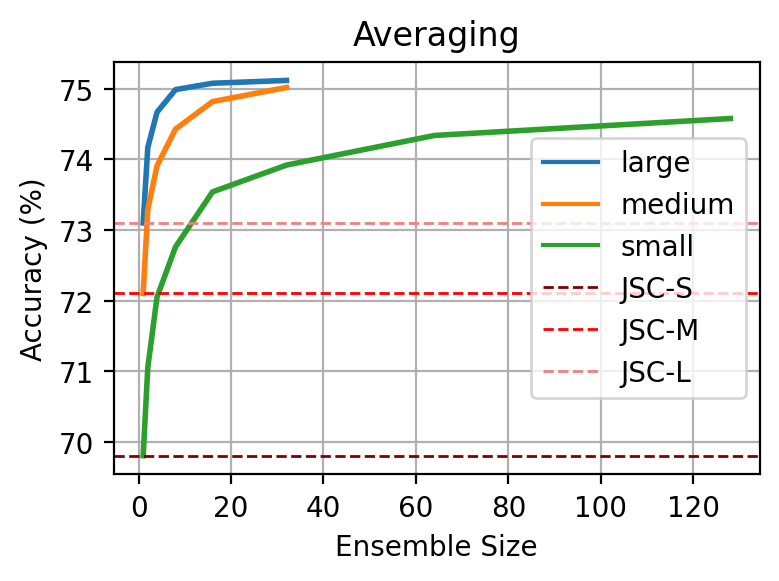

In [5]:
"""
Line plot of accuracy vs ensemble size
"""
plot_df = df.loc[df["model_size"].isin(["small", "medium", "large"])]
display(plot_df)
fig, ax = plt.subplots(figsize=(4, 3))
ax = sns.lineplot(
    data=plot_df, 
    x="ensemble_size", 
    y="accuracy", 
    ax=ax, 
    hue="model_size", 
    linewidth=2,
    # label="JSC-S Ensemble"
)
plt.axhline(y=69.8, linewidth=1, linestyle="--", color="maroon", label="JSC-S")
plt.axhline(y=72.1, linewidth=1, linestyle="--", color="red", label="JSC-M")
plt.axhline(y=73.1, linewidth=1, linestyle="--", color="lightcoral", label="JSC-L")
ax.grid()
ax.legend()
ax.set_title("Averaging")
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Ensemble Size")
fig.tight_layout()
plt.savefig("averaging_acc_v_ensemble_size_lineplot.pdf")
plt.savefig("averaging_acc_v_ensemble_size_lineplot.png")

,trial,accuracy,loss,ensemble_size,model_size
35,small_same_output_scale_post_trans_ensemble_si...,73.54,0.781,128,small_same_output_scale_post_trans
42,small_same_output_scale_post_trans_ensemble_si...,73.05,0.803,32,small_same_output_scale_post_trans
44,small_same_output_scale_post_trans_ensemble_si...,72.91,0.801,32,small_same_output_scale_post_trans
47,small_same_output_scale_ensemble_size16,72.50,0.843,16,small_same_output_scale
48,small_same_output_scale_post_trans_ensemble_si...,72.44,0.810,64,small_same_output_scale_post_trans
49,small_same_output_scale_post_trans_ensemble_si...,72.15,0.832,16,small_same_output_scale_post_trans
50,small_same_output_scale_post_trans_ensemble_si...,72.12,0.844,8,small_same_output_scale_post_trans
54,small_same_output_scale_post_trans_ensemble_si...,71.96,0.851,16,small_same_output_scale_post_trans
55,small_same_output_scale_post_trans_ensemble_si...,71.95,0.830,8,small_same_output_scale_post_trans
58,small_same_output_scale_ensemble_size8,71.68,0.869,8,small_same_output_scale


/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


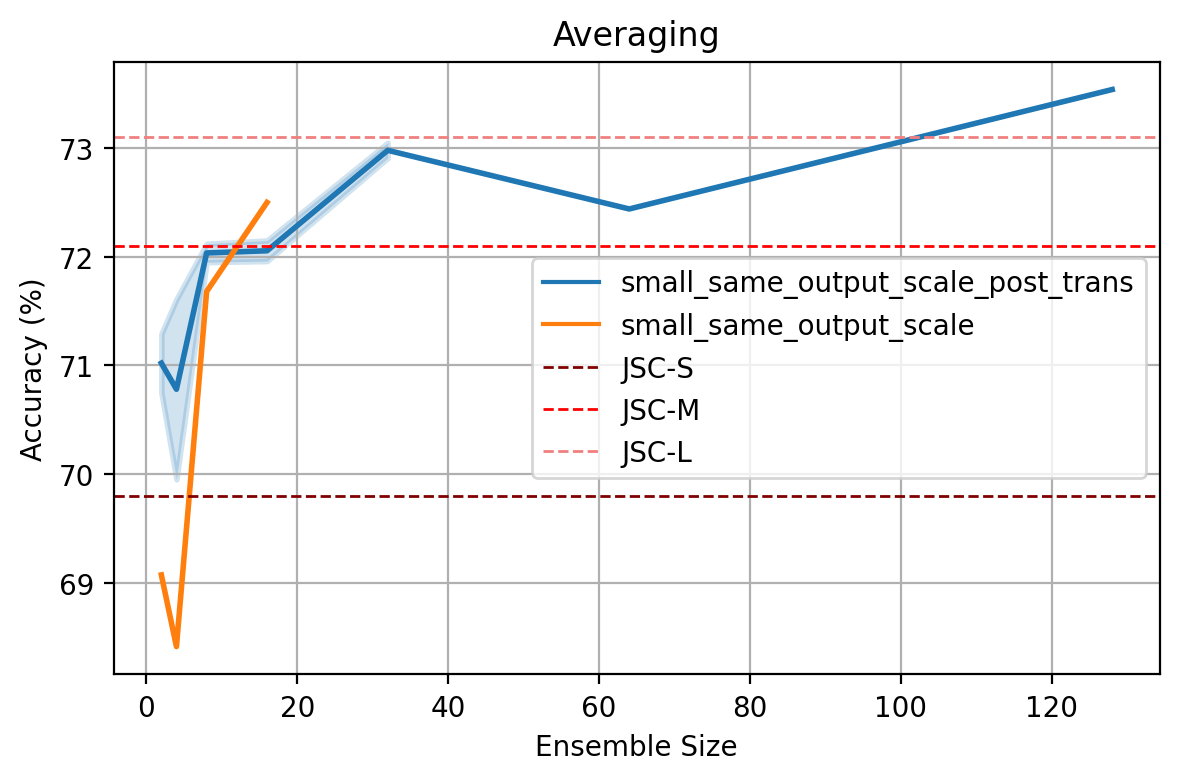

In [7]:
plot_two_ensembles(df, "small_same_output_scale_post_trans", "small_same_output_scale")

,trial,accuracy,loss,ensemble_size,model_size
6,averaging_medium_ensemble_size32,75.02,0.693,32,medium
11,averaging_medium_ensemble_size16,74.82,0.698,16,medium
19,averaging_medium_ensemble_size8,74.43,0.709,8,medium
21,medium_same_output_scale_post_trans_ensemble_s...,74.33,0.731,16,medium_same_output_scale_post_trans
22,medium_same_output_scale_post_trans_ensemble_s...,74.30,0.737,8,medium_same_output_scale_post_trans
30,averaging_medium_ensemble_size4,73.91,0.728,4,medium
31,medium_same_output_scale_post_trans_ensemble_s...,73.82,0.736,4,medium_same_output_scale_post_trans
38,averaging_medium_ensemble_size2,73.29,0.748,2,medium
39,medium_same_output_scale_post_trans_ensemble_s...,73.23,0.751,2,medium_same_output_scale_post_trans
51,best_single_model_medium,72.10,0.000,1,medium


/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


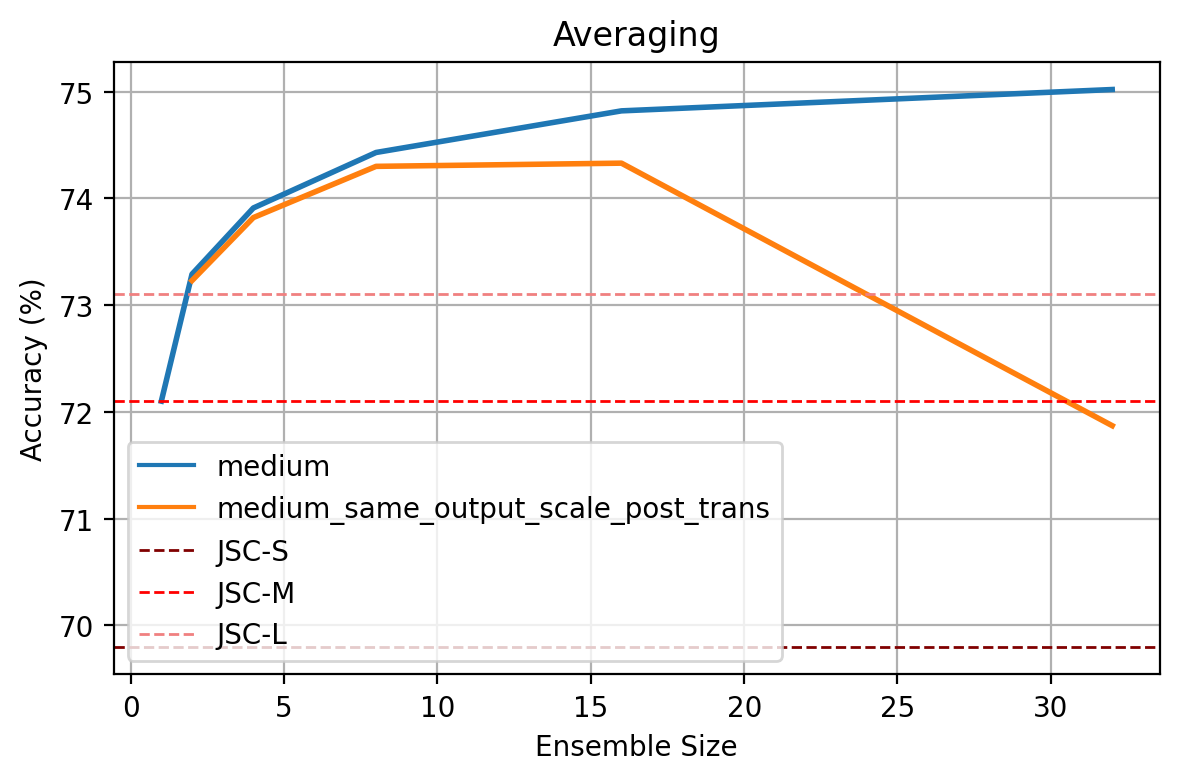

In [6]:
plot_two_ensembles(df, "medium", "medium_same_output_scale_post_trans")

,trial,accuracy,loss,ensemble_size,model_size
3,averaging_large_ensemble_size32,75.12,0.688,32,large
4,averaging_large_ensemble_size16,75.08,0.689,16,large
7,large_same_output_scale_post_trans_ensemble_si...,75.01,0.694,16,large_same_output_scale_post_trans
8,averaging_large_ensemble_size8,74.99,0.693,8,large
12,large_same_output_scale_post_trans_ensemble_size8,74.76,0.707,8,large_same_output_scale_post_trans
13,averaging_large_ensemble_size4,74.67,0.703,4,large
15,large_same_output_scale_post_trans_ensemble_size4,74.58,0.710,4,large_same_output_scale_post_trans
24,averaging_large_ensemble_size2,74.17,0.718,2,large
26,large_same_output_scale_post_trans_ensemble_size2,73.99,0.723,2,large_same_output_scale_post_trans
37,large_same_output_scale_post_trans_ensemble_si...,73.39,0.734,32,large_same_output_scale_post_trans


/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


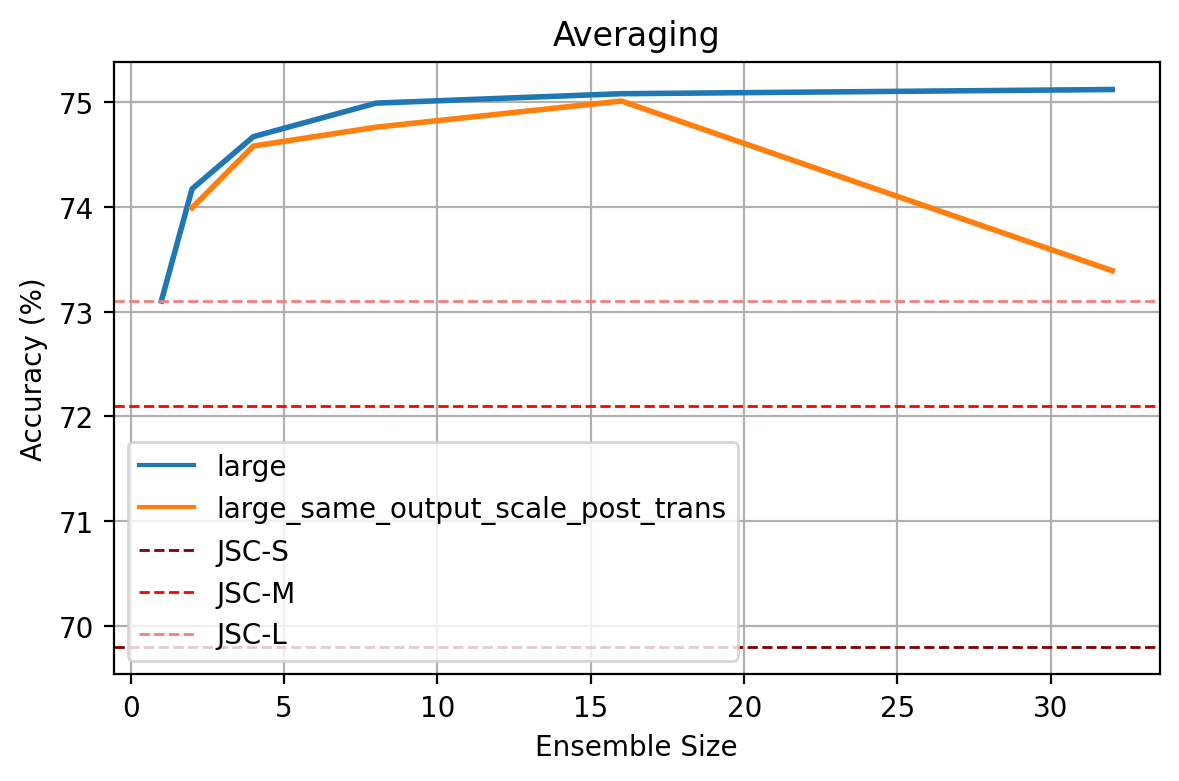

In [7]:
plot_two_ensembles(df, "large", "large_same_output_scale_post_trans")

## Bagging

In [8]:
experiment_dir = "../bagging"
df = parse_seq_ensemble_exp(experiment_dir)
df = add_single_model_data(df)
df = df.sort_values("accuracy", ignore_index=True, ascending=False)
bagging_df = df
df

,trial,accuracy,loss,ensemble_size,model_size
0,bagging_large_independent_ensemble_size32,73.700,0.727,8,large_independent
1,bagging_large_independent_ensemble_size32,73.661,0.728,7,large_independent
2,bagging_large_ensemble_size32,73.657,0.728,27,large
3,bagging_large_ensemble_size32,73.657,0.728,31,large
4,bagging_large_ensemble_size32,73.655,0.728,18,large
...,...,...,...,...,...
136,bagging_small_independent_ensemble_size32,71.011,0.843,3,small_independent
137,bagging_small_independent_ensemble_size32,70.731,0.860,2,small_independent
138,bagging_small_ensemble_size32,70.261,0.894,1,small
139,bagging_small_independent_ensemble_size32,70.261,0.894,1,small_independent


,trial,accuracy,loss,ensemble_size,model_size
0,bagging_large_independent_ensemble_size32,73.700,0.727,8,large_independent
1,bagging_large_independent_ensemble_size32,73.661,0.728,7,large_independent
2,bagging_large_ensemble_size32,73.657,0.728,27,large
3,bagging_large_ensemble_size32,73.657,0.728,31,large
4,bagging_large_ensemble_size32,73.655,0.728,18,large
...,...,...,...,...,...
136,bagging_small_independent_ensemble_size32,71.011,0.843,3,small_independent
137,bagging_small_independent_ensemble_size32,70.731,0.860,2,small_independent
138,bagging_small_ensemble_size32,70.261,0.894,1,small
139,bagging_small_independent_ensemble_size32,70.261,0.894,1,small_independent


/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


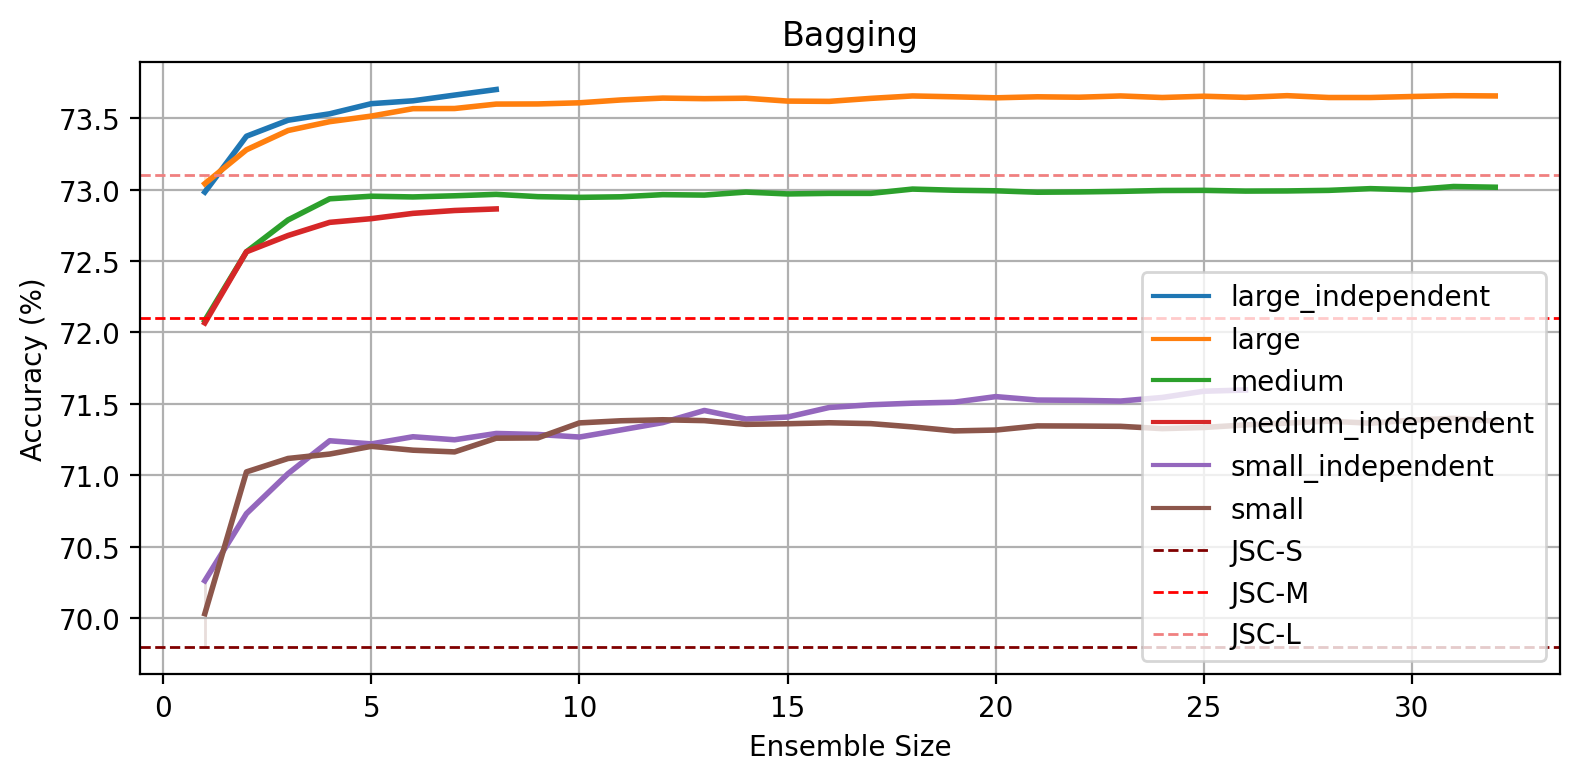

In [9]:
"""
Line plot of accuracy vs ensemble size
"""
plot_df = df
# plot_df = df.loc[df["model_size"].isin(["small", "medium", "large"])]
display(plot_df)
fig, ax = plt.subplots(figsize=(8, 4))
ax = sns.lineplot(
    data=plot_df, 
    x="ensemble_size", 
    y="accuracy", 
    ax=ax, 
    hue="model_size", 
    linewidth=2,
    # label="JSC-S Ensemble"
)
plt.axhline(y=69.8, linewidth=1, linestyle="--", color="maroon", label="JSC-S")
plt.axhline(y=72.1, linewidth=1, linestyle="--", color="red", label="JSC-M")
plt.axhline(y=73.1, linewidth=1, linestyle="--", color="lightcoral", label="JSC-L")
ax.grid()
ax.legend()
ax.set_title("Bagging")
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Ensemble Size")
fig.tight_layout()
plt.savefig("bagging_acc_v_ensemble_size_lineplot.pdf")
plt.savefig("bagging_acc_v_ensemble_size_lineplot.png")

## AdaBoost

In [10]:
experiment_dir = "../adaboost"
df = parse_seq_ensemble_exp(experiment_dir)
df = add_single_model_data(df)
df = df.sort_values("accuracy", ignore_index=True, ascending=False)
adaboost_df = df
df

,trial,accuracy,loss,ensemble_size,model_size
0,best_single_model_large,73.100,0.000,1,large
1,adaboost_large_ensemble_size32,72.996,1.164,3,large
2,adaboost_large_ensemble_size32,72.996,1.101,1,large
3,adaboost_large_independent_ensemble_size32,72.996,1.162,3,large_independent
4,adaboost_large_ensemble_size32,72.996,1.131,2,large
...,...,...,...,...,...
68,adaboost_small_ensemble_size32,69.717,1.327,14,small
69,adaboost_small_ensemble_size32,69.701,1.271,8,small
70,adaboost_small_ensemble_size32,69.681,1.287,9,small
71,adaboost_small_ensemble_size32,69.650,1.297,10,small


,trial,accuracy,loss,ensemble_size,model_size
0,best_single_model_large,73.100,0.000,1,large
1,adaboost_large_ensemble_size32,72.996,1.164,3,large
2,adaboost_large_ensemble_size32,72.996,1.101,1,large
3,adaboost_large_independent_ensemble_size32,72.996,1.162,3,large_independent
4,adaboost_large_ensemble_size32,72.996,1.131,2,large
...,...,...,...,...,...
68,adaboost_small_ensemble_size32,69.717,1.327,14,small
69,adaboost_small_ensemble_size32,69.701,1.271,8,small
70,adaboost_small_ensemble_size32,69.681,1.287,9,small
71,adaboost_small_ensemble_size32,69.650,1.297,10,small


/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


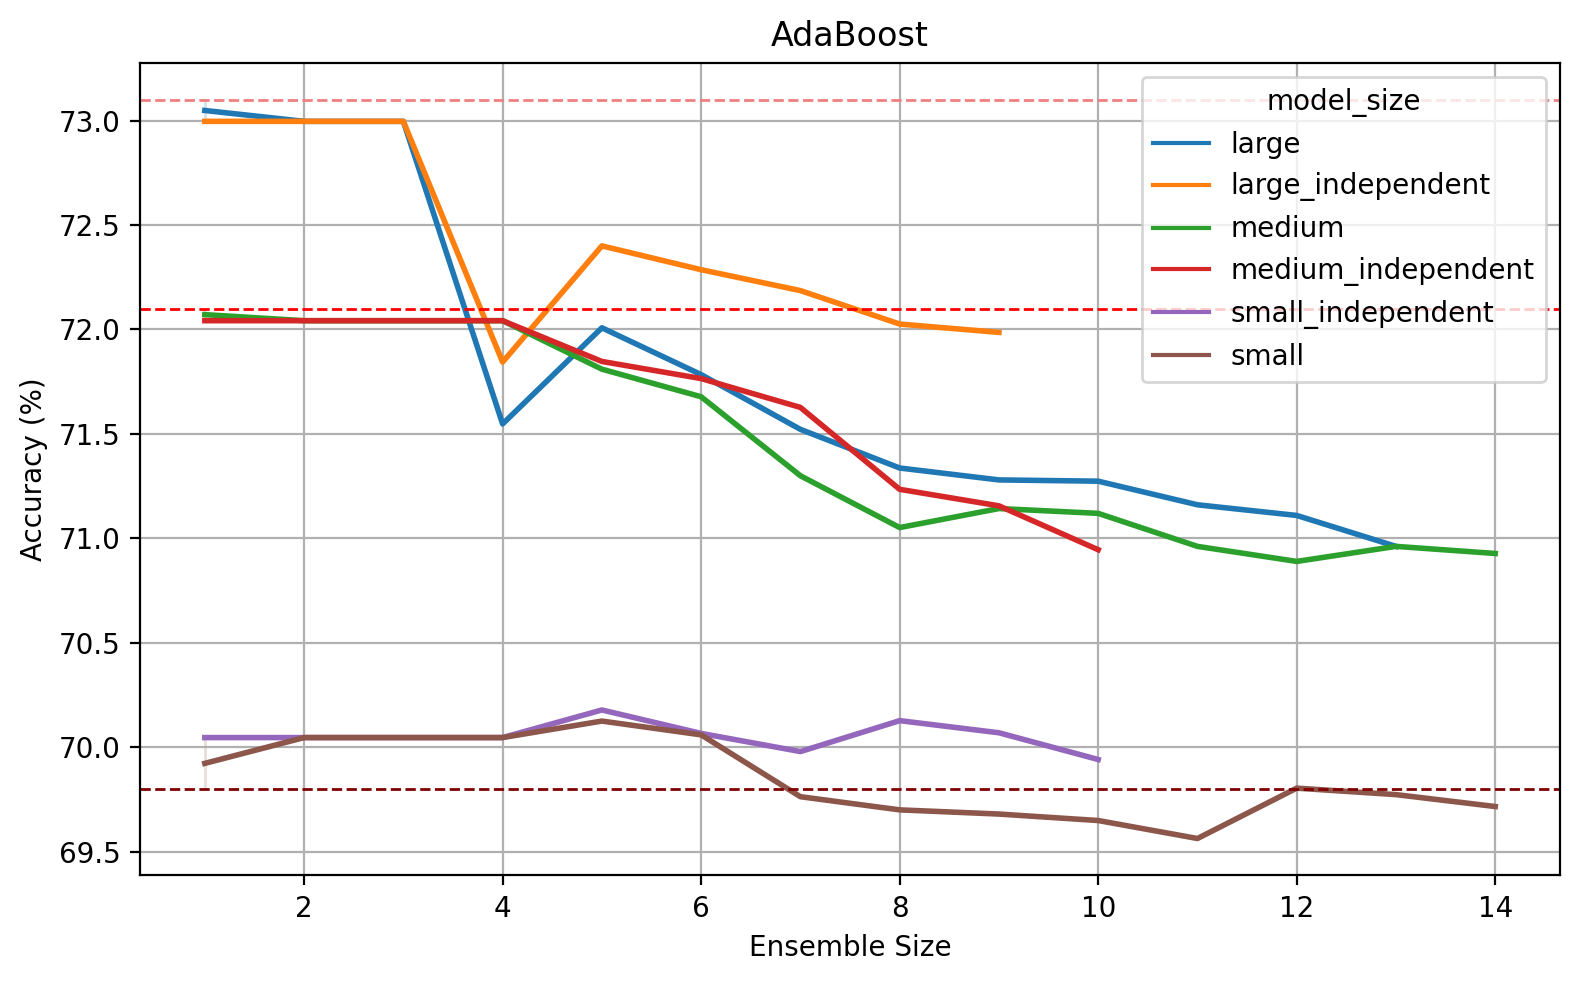

In [11]:
"""
Line plot of accuracy vs ensemble size
"""
plot_df = df
# plot_df = df.loc[df["model_size"].isin(["small", "medium", "large"])]
display(plot_df)
fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.lineplot(
    data=plot_df, 
    x="ensemble_size", 
    y="accuracy", 
    ax=ax, 
    hue="model_size", 
    linewidth=2,
)
plt.axhline(y=69.8, linewidth=1, linestyle="--", color="maroon", label="JSC-S")
plt.axhline(y=72.1, linewidth=1, linestyle="--", color="red", label="JSC-M")
plt.axhline(y=73.1, linewidth=1, linestyle="--", color="lightcoral", label="JSC-L")
ax.grid()
# ax.legend()
ax.set_title("AdaBoost")
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Ensemble Size")
fig.tight_layout()
plt.savefig("adaboost_acc_v_ensemble_size_lineplot.pdf")
plt.savefig("adaboost_acc_v_ensemble_size_lineplot.png")

## Ensembling Comparison

In [63]:
# avg_df = averaging_df.loc[averaging_df["model_size"].isin(["small", "medium", "large"])]
# TODO: Pull out qavg results from averaging df
averaging_df["ensemble_method"] = averaging_df["model_size"].apply(lambda x: "Averaging")
bagging_df["ensemble_method"] = bagging_df["model_size"].apply(lambda x: "Bagging")
all_df = pd.concat([averaging_df, bagging_df])
all_df = add_single_model_data(all_df)
all_df

,trial,accuracy,loss,ensemble_size,model_size,ensemble_method
0,averaging_large_ensemble_size32,75.120,0.688,32,large,Averaging
1,averaging_large_ensemble_size16,75.080,0.689,16,large,Averaging
2,averaging_medium_ensemble_size32,75.020,0.693,32,medium,Averaging
3,averaging_large_ensemble_size8,74.990,0.693,8,large,Averaging
4,large_qavg_ensemble_size6,74.950,0.695,6,large_qavg,Averaging
...,...,...,...,...,...,...
126,bagging_small_ensemble_size32,70.261,0.894,1,small,Bagging
127,best_single_model_small,69.800,0.000,1,small,Bagging
128,best_single_model_small,69.800,0.000,1,small,NaN
129,best_single_model_medium,72.100,0.000,1,medium,NaN


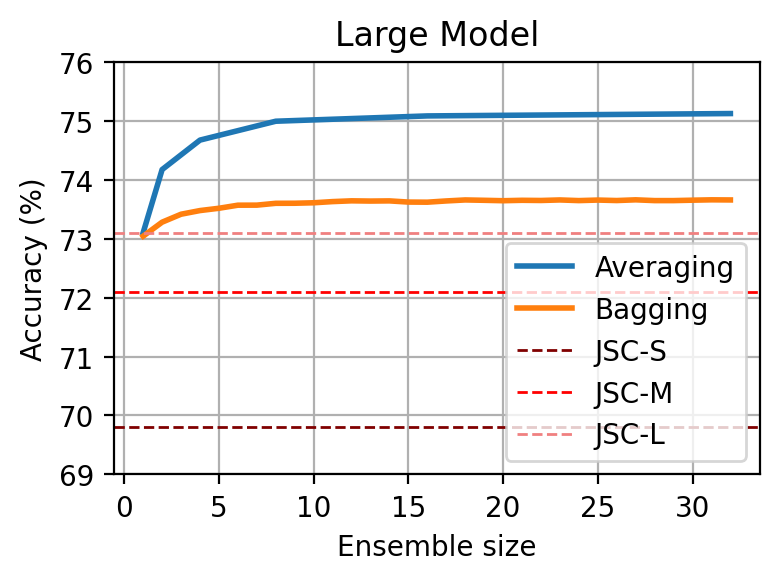

In [37]:
# Line plot for large model
fig, ax = plt.subplots(figsize=(4, 3))

large_df = all_df[all_df["model_size"] == "large"]
ax = sns.lineplot(
    data=large_df, 
    x="ensemble_size", 
    y="accuracy", 
    hue="ensemble_method", 
    errorbar=(lambda x: (x.min(), x.max())), 
    err_kws={"linewidth": 2}, 
    linewidth=2,
)

plt.axhline(y=69.8, linewidth=1, linestyle="--", color="maroon", label="JSC-S")
plt.axhline(y=72.1, linewidth=1, linestyle="--", color="red", label="JSC-M")
plt.axhline(y=73.1, linewidth=1, linestyle="--", color="lightcoral", label="JSC-L")

ax.grid()
ax.legend(loc="lower right")
ax.set_ylim([69, 76])
ax.set_xlabel("Ensemble size")
ax.set_ylabel("Accuracy (%)")
ax.set_title("Large Model")

fig.tight_layout()

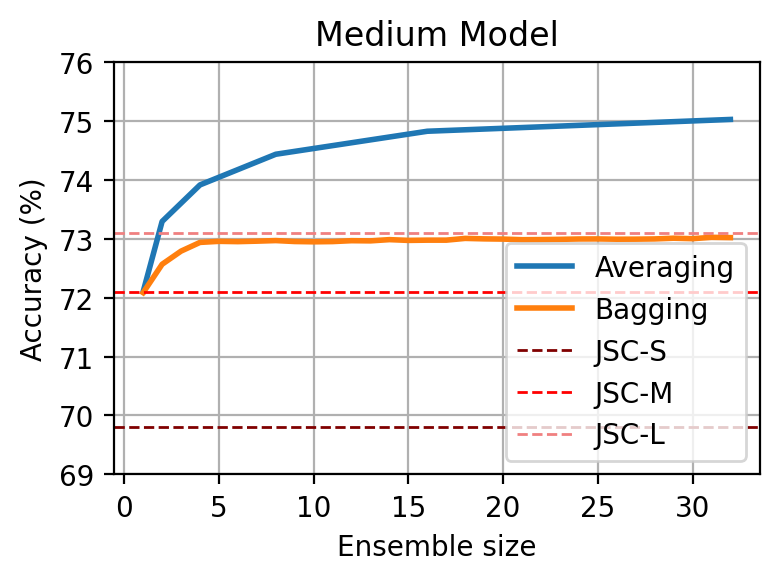

In [34]:
# Line plot for medium model
fig, ax = plt.subplots(figsize=(4, 3))

large_df = all_df[all_df["model_size"] == "medium"]
ax = sns.lineplot(
    data=large_df, 
    x="ensemble_size", 
    y="accuracy", 
    hue="ensemble_method", 
    errorbar=(lambda x: (x.min(), x.max())), 
    err_kws={"linewidth": 2}, 
    linewidth=2,
)

plt.axhline(y=69.8, linewidth=1, linestyle="--", color="maroon", label="JSC-S")
plt.axhline(y=72.1, linewidth=1, linestyle="--", color="red", label="JSC-M")
plt.axhline(y=73.1, linewidth=1, linestyle="--", color="lightcoral", label="JSC-L")

ax.grid()
ax.legend()
ax.set_ylim([69, 76])
ax.set_xlabel("Ensemble size")
ax.set_ylabel("Accuracy (%)")
ax.set_title("Medium Model")

fig.tight_layout()

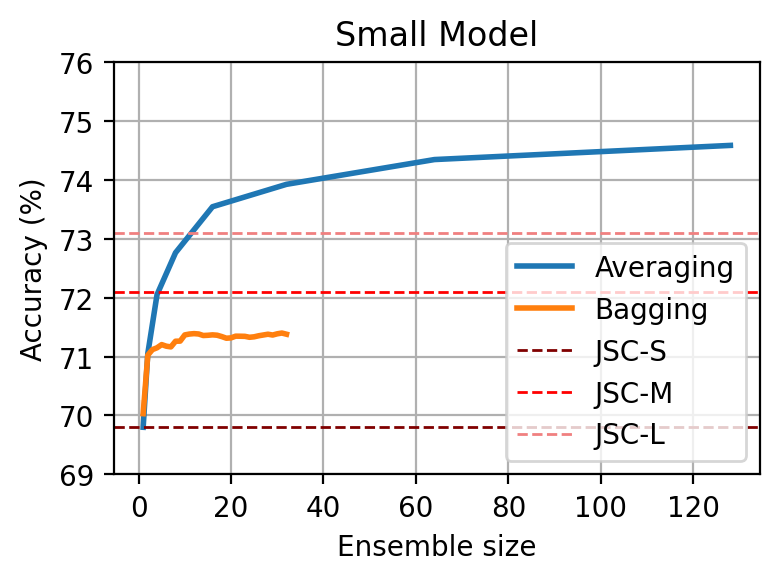

In [33]:
# Line plot for small model
fig, ax = plt.subplots(figsize=(4, 3))

large_df = all_df[all_df["model_size"] == "small"]
ax = sns.lineplot(
    data=large_df, 
    x="ensemble_size", 
    y="accuracy", 
    hue="ensemble_method", 
    errorbar=(lambda x: (x.min(), x.max())), 
    err_kws={"linewidth": 2}, 
    linewidth=2,
)

plt.axhline(y=69.8, linewidth=1, linestyle="--", color="maroon", label="JSC-S")
plt.axhline(y=72.1, linewidth=1, linestyle="--", color="red", label="JSC-M")
plt.axhline(y=73.1, linewidth=1, linestyle="--", color="lightcoral", label="JSC-L")

ax.grid()
ax.legend()
ax.set_ylim([69, 76])
ax.set_xlabel("Ensemble size")
ax.set_ylabel("Accuracy (%)")
ax.set_title("Small Model")

fig.tight_layout()

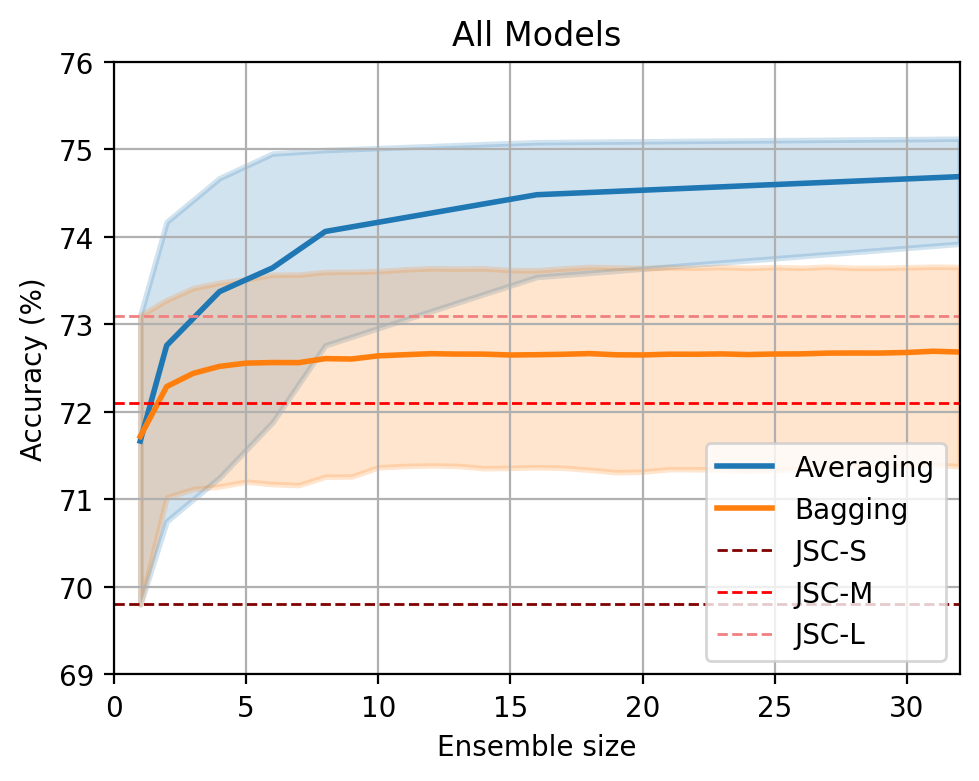

In [56]:
# Line plot for all
fig, ax = plt.subplots(figsize=(5, 4))

ax = sns.lineplot(
    data=all_df, 
    x="ensemble_size", 
    y="accuracy", 
    hue="ensemble_method", 
    errorbar=(lambda x: (x.min(), x.max())), 
    err_kws={"linewidth": 2}, 
    linewidth=2,
)

plt.axhline(y=69.8, linewidth=1, linestyle="--", color="maroon", label="JSC-S")
plt.axhline(y=72.1, linewidth=1, linestyle="--", color="red", label="JSC-M")
plt.axhline(y=73.1, linewidth=1, linestyle="--", color="lightcoral", label="JSC-L")

ax.grid()
ax.legend(loc="lower right")
ax.set_ylim([69, 76])
ax.set_xlim([0, 32])
ax.set_xlabel("Ensemble size")
ax.set_ylabel("Accuracy (%)")
ax.set_title("All Models")

fig.tight_layout()